In [19]:
from random import shuffle, random
from itertools import chain
import pygad
from pygad import kerasga
import numpy as np
from tensorflow import keras

In [144]:
class Game:
    weight_names = sum(([
        "Prize",
        "Turn",
        "Multiplier",
        "Closed Gate",
        "Chance to fail",
        "Random",
        ],
         ["Total Warriors"],
         [f'Total {i}' for i in range(1, 8)],
         ["Warriors on last row"],
         [f'{i} on last row' for i in range(1, 8)]
    ), [])


    def __init__(self):
        deck = list(chain(*tuple(([i] * 10 for i in range(1, 8)))))
        deck += 4*[0]
        shuffle(deck)
        self.deck = deck

        self.rows = 8 * [[]]

        self.i_card = 0
        self.rows[0] = [self.draw_card()]
        self.rows[1] = [self.draw_card(), self.draw_card()]

        self.i_row = 2

        if self.rows[1][0] == self.rows[1][1]:
            self.multiplier = 2
        else:
            self.multiplier = 1

        self.win = True
        self.stopped = False

    def draw_card(self):
        card = self.deck[self.i_card]
        self.i_card += 1
        return card

    def next(self):
        self.rows[self.i_row] = [self.draw_card() for _ in range(self.i_row + 1)]

        r = self.rows[self.i_row]
        pr = self.rows[self.i_row - 1]

        self.i_row += 1

        if 0 in r:
            return

        for i in range(len(pr)):
            if r[i] == pr[i] or r[i + 1] == pr[i]:
                if not self.rows[0] or self.rows[0][0] == r[i]:
                    self.win = False
                    return

                self.rows[self.i_row - 1][i] = self.rows[0][0]
                self.rows[0] = []

        if r.count(r[0]) == len(r):
            self.multiplier = len(r)
    
    def stop(self):
        self.stopped = True

    @property
    def cards_on_table(self):
        i_start = 1 if self.rows[0] else 0
        known_cards = self.deck[i_start:self.i_card]
        return [known_cards.count(k) for k in range(8)]

    @property
    def cards_on_last_row(self):
        row = self.rows[self.i_row - 1]
        return [row.count(k) for k in range(8)]
    
    @property
    def remaining_cards_count_normalized(self):
        c = self.remaining_cards
        c = [c.count(k) for k in range(8)]
        c[0] /= 4
        c[1:] = [v / 10 for v in c[1:]]
        return c

    @property
    def prize(self):
        i_row = self.i_row - 1
        if i_row == 7 and self.win:
            prize = self.multiplier * sum(sum(r) for r in self.rows[1:])
        elif self.win:
            prize = self.multiplier * sum(self.rows[i_row])
        else:
            prize = 0

        return prize - 15

    @property
    def remaining_cards(self):
        if self.rows[0]:
            return self.deck[self.i_card:]
        else:
            return self.deck[self.i_card:] + [self.deck[0]]

    @property
    def chance_to_fail(self):
        c = self.remaining_cards
        r = self.rows[self.i_row - 1]

        nc = len(c)
        pw = self.i_row * c.count(0) / nc

        res = c.count(r[0]) * bool(r[0]) + c.count(r[-1]) * bool(r[-1])
        for i in range(0, len(r) - 1):
            res += c.count([i]) * bool(r[i]) + c.count(r[i+1]) * bool(r[i+1])

        return (res / nc) * (1 - pw)


    @property
    def finished(self):
        return self.i_row == 8 or not self.win or self.stopped

    @property
    def vector_state(self):
        return np.array(
            [
                self.prize,
                self.i_row,
                self.multiplier,
                len(self.rows[0]),
                self.chance_to_fail,
                random() - 0.5,
        ] 
        + self.cards_on_table 
        + self.cards_on_last_row
        )

    @property
    def vector_state_full(self):
        r = self.rows[self.i_row - 1]
        en_r = [0] * len(self.rows) * 8

        for i, v in enumerate(r):
            en_r[i*8 + v] = 1

        return np.array(
            [
                self.prize / 1328,
                self.i_row / 8,
                self.multiplier / 8,
                len(self.rows[0]),
                random() - 0.5,
            ]
            + self.remaining_cards_count_normalized
            + en_r
        )


class StupidPlayer:
    def __init__(self, i_max):
        self.i_max = i_max

    def play(self, g):
        while g.i_row != self.i_max:
            g.next()
            if not g.win:
                break

        return g

class SmartPlayer:
    def __init__(self, weights):
        self.w = weights

    def play(self, g):
        while not g.finished:
            score = np.sum(self.w[1:] * g.vector_state)

            if score < self.w[0]:
                break

            g.next()
            
        return g

class NeuralPlayer:
    def __init__(self, solution = None):

        model = keras.Sequential()
        model.add(keras.layers.Input(77))
        model.add(keras.layers.Dense(10, activation="relu"))
        model.add(keras.layers.Dense(1, activation="linear"))
        model.build()

        self.solution = solution
        self.brain = model

    def fitness(self, ga_instance, solution, sol_ids):
        N = 10000
        self.solution = solution

        gs = [Game() for _ in range(N)]
        self.play(gs)
        total_prize = sum(g.prize for g in gs)

        return total_prize / N

    def play(self, gs):
        while not all(g.finished for g in gs):
            cgs = [g for g in gs if not g.finished]
            data = np.stack([g.vector_state_full for g in cgs])

            prediction = kerasga.predict(model=self.brain, solution=self.solution, data=data)

            for g, p in zip(cgs, prediction):
                if p > 0.5:
                    g.next()
                else:
                    g.stop()
            
        return gs

def fitness_func(ga_instance, solution, solution_ids):
    N = 10000
    p = SmartPlayer(solution)

    total_prize = 0
    for _ in range(N):
        g = Game()
        p.play(g)
        total_prize += g.prize

    return total_prize / N


In [145]:
p = NeuralPlayer()

keras_ga = kerasga.KerasGA(p.brain, 10)

ga_instance = pygad.GA(
   num_generations=5,
   num_parents_mating=4,
   sol_per_pop=10,
   crossover_probability=0.5,
   mutation_probability=0.5,
   fitness_func=p.fitness,
   initial_population=keras_ga.population_weights,
   # keep_elitism=0,
   # keep_parents=0,
   save_solutions=True,
   save_best_solutions=False,
   #parent_selection_type='tournament'
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


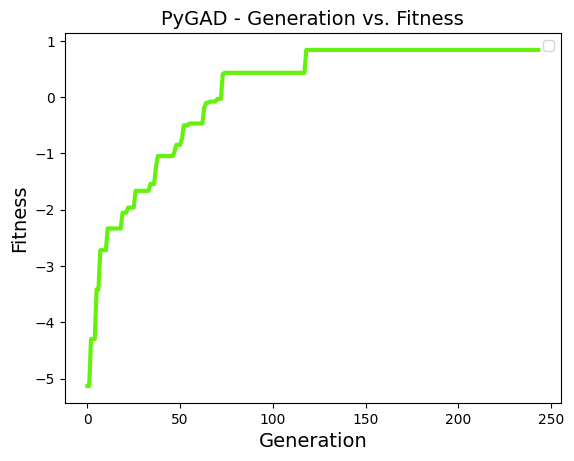

(0.8386,
 array([ 1.48379823e+00,  3.04979770e+00, -1.31875198e-02, -7.49331990e+00,
        -4.52910135e+00,  8.32260858e-01,  4.53958797e+00, -2.24343319e+00,
        -1.62016960e+00, -5.14921481e-01, -3.15430222e+00, -2.36548953e+00,
         6.56774389e+00, -2.34217868e+00, -5.58480674e+00, -2.24001859e+00,
         6.07667951e+00, -4.64503661e-01, -2.15691759e+00,  6.59949276e+00,
        -3.39528076e-01, -5.20222012e+00,  2.32390360e+00, -3.25889073e+00,
        -1.21258449e+00, -2.64151525e+00, -1.26284321e+00, -1.71701961e+00,
         3.86474574e-01, -2.61590899e+00, -1.55124854e+00, -2.38006845e+00,
         8.03825017e+00, -3.34872481e+00, -1.06748518e+01,  9.43129692e-01,
        -3.13239917e+00,  9.36387538e+00,  1.26306766e+00,  8.99031476e+00,
        -7.45021789e-01, -3.42192070e+00,  3.70733678e+00, -3.20995441e+00,
         5.50110060e+00,  2.80576945e+00,  4.81272927e-01,  1.84442031e+00,
         3.96757414e-01,  2.09347369e+00,  1.56402164e+00,  1.59426935e+00,
   

In [172]:
ga_instance.run()

ga_instance.plot_fitness()
w, score, _ = ga_instance.best_solution()
p.solution = w
score, w

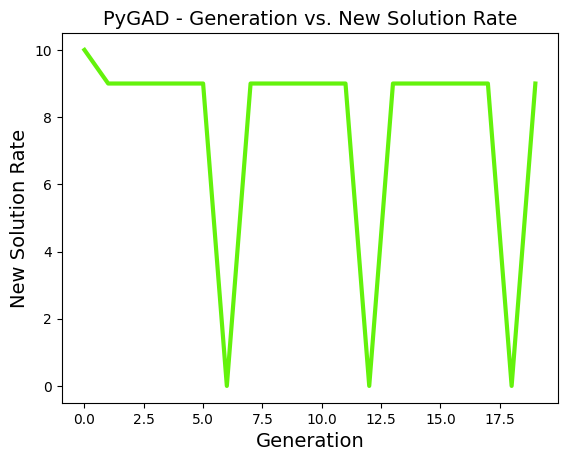

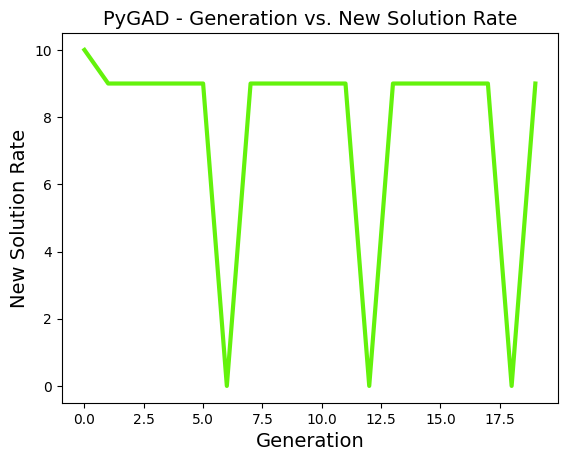

In [154]:
ga_instance.plot_new_solution_rate()
#ga_instance.plot_genes(graph_type="boxplot")

In [178]:
total = 0
n = 10000
gs = [Game() for _ in range(n)]
total = sum(g.prize for g in p.play(gs))
total / n

0.073

In [165]:
g = Game()
print(g.rows)
print(g.chance_to_fail)
print(g.vector_state_full)
len(g.vector_state_full)

[[5], [0, 6], [], [], [], [], [], []]
0.23209680618924816
[-0.00677711  0.25        0.125       1.         -0.09304492  0.75
  1.          1.          1.          1.          0.9         0.9
  1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]


77

In [212]:
g.next()
print(g.win)
print(g.rows)
print(g.chance_to_fail)

False
[[], [5, 3], [0, 5, 1], [2, 4, 6, 6], [3, 3, 7, 1, 5], [4, 4, 5, 2, 0, 3], [4, 7, 6, 3, 3, 7, 2], []]
0.5531914893617021


In [10]:
8 * (7 * 8 + 6 * 7 + 5 * 6 + 4 * 5 + 3 * 4 + 3 * 2)

1328

In [164]:
ga_instance.num_generations = 100